In [1]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
import json
import pandas as pd
import numpy as np
import seaborn as sns
import math
import skimage.measure
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import os
import random

In [2]:
def loadGazeSession_session(path):
    with open("saved_gazedata/" + path) as f:
        data = json.load(f)
    X = []
    for d in data:
        for i in range(d["value"]):
            cord = [d["x"], d["y"]]
            X.append(cord)
    X = np.array(X)
    print("loaded {} >> {}".format(path, X.shape))
    return X

In [3]:
def point_dist(x1, y1, x2, y2):
    return np.math.sqrt((x2-x1)**2 + (y2-y1)**2)

def getClusterCentroid(points_df):
    return tuple(points_df.mean())

def getIntraClusterDistance(points_df, times=1000):
    sum = 0
    for idx, ipt in points_df.iterrows():
        x1 = ipt["x0"]*times
        y1 = ipt["x1"]*times
        for jdx, jpt in points_df.iterrows():
            x2 = jpt["x0"]*times
            y2 = jpt["x1"]*times
        sum += point_dist(x1, y1, x2, y2)

    intra_dist_times_1000 = sum/(len(points_df)**2)
    return intra_dist_times_1000

def getSingleCluster__attrs(points_df):
    return {
        "num points": len(points_df),
        "center"    : getClusterCentroid(points_df),
        "intra_dist": getIntraClusterDistance(points_df, times=1000)
    }


In [4]:
path_arr = [
    "user_1/bottom_left.json",
    "user_2/bottom_right.json",
    "user_3/upper_right.json",
    "user_4/upper_left.json",
]
path_arr_2d = [path_arr, path_arr, path_arr]
len(path_arr_2d)

3

In [5]:
user_1 = os.listdir("saved_gazedata/user_1")
user_2 = os.listdir("saved_gazedata/user_2")
user_3 = os.listdir("saved_gazedata/user_3")
user_4 = os.listdir("saved_gazedata/user_4")

user_files = [user_1, user_2, user_3, user_4]

# path_all_combinations = []
# for p1 in user_1:
#     path1 = "user_1/" + p1
#     for p2 in user_2:
#         path2 = "user_2/" + p2
#         for p3 in user_3:
#             path3 = "user_3/" + p3
#             for p4 in user_4:
#                 path4 = "user_4/" + p4
#                 path_all_combinations.append([path1, path2, path3, path4])
# random.shuffle(path_all_combinations)
# len(path_all_combinations)

In [6]:
regions = [
    "bottom_left", "bottom_mid", "bottom_right",
    "mid_left", "mid_mid", "mid_right",
    "upper_left", "upper_mid", "upper_right"
]

In [7]:
region2file = {}

for region in regions:
    region2file[region] = []
region2file["misc"] = []

for uid in range(len(user_files)):
    user = "user_{}/".format(uid+1)
    for f in user_files[uid]:
        match_region = False
        for region in regions:
            if (region in f) and ("bad_gaze" not in f):
                region2file[region].append(user+f)
                match_region = True
                break
        if(match_region == False):
            region2file["misc"].append(user + f)

# region2file

In [8]:
#############################################################################
limiter = 10
path_all_combinations = []
#############################################################################

# All Same Region

In [9]:
path_all_combinations = []

for region in regions:
    path = region2file[region]
    path_all_combinations.append(path)

# path_all_combinations

# 1-2 Different Regions

In [10]:
########################################################################
total_choice = 4
num_same = 2
########################################################################

path_all_combinations = []
while(len(path_all_combinations) < limiter):
    same_region = random.choice(regions)
    taken = random.sample(region2file[same_region], k = num_same)
    not_taken = []
    for region in region2file.keys():
        if(region == same_region):
            continue
        for f in region2file[region]:
            not_taken.append(f)
    taken += random.choices(not_taken, k=total_choice - num_same)
    path_all_combinations.append(taken)

# All different

In [11]:
total_choice = 4

path_all_combinations = []
while(len(path_all_combinations) < limiter):
    cur_regions = random.sample(regions, k = total_choice)
    taken = []
    for region in cur_regions:
        taken.append(random.choice(region2file[region]))
    path_all_combinations.append(taken)

In [12]:
len(path_all_combinations), path_all_combinations

(10,
 [['user_4/mid_mid.json',
   'user_1/mid_right.json',
   'user_2/upper_right.json',
   'user_3/bottom_mid.json'],
  ['user_1/bottom_left.json',
   'user_4/upper_left.json',
   'user_4/upper_right.json',
   'user_3/bottom_mid.json'],
  ['user_1/bottom_right.json',
   'user_4/mid_left.json',
   'user_2/upper_right.json',
   'user_1/mid_right.json'],
  ['user_3/upper_left.json',
   'user_4/mid_mid.json',
   'user_3/mid_left.json',
   'user_1/bottom_left.json'],
  ['user_1/upper_right.json',
   'user_2/mid_mid.json',
   'user_1/bottom_right.json',
   'user_2/bottom_mid.json'],
  ['user_4/upper_mid.json',
   'user_3/upper_left.json',
   'user_2/bottom_mid.json',
   'user_1/upper_right.json'],
  ['user_4/mid_left.json',
   'user_1/bottom_left.json',
   'user_4/upper_left.json',
   'user_1/upper_right.json'],
  ['user_1/bottom_left.json',
   'user_1/bottom_mid.json',
   'user_2/mid_mid.json',
   'user_3/upper_left.json'],
  ['user_1/upper_left.json',
   'user_3/bottom_right.json',
   'us

# Generate Analysis Figures

loaded user_4/mid_mid.json >> (89, 2)
loaded user_1/mid_right.json >> (82, 2)
loaded user_2/upper_right.json >> (84, 2)
loaded user_3/bottom_mid.json >> (84, 2)
 >>>> Loaded dataset >>>  (339, 2)
heatmap shape (1001, 1001)
(11, 11) 0.0 0.0047
>>>>  1
(339, 11) (339, 11)
Knee >>  0.07343704787094868
Number of clusters:  3
-1 >> number of points: 19; center: (0.7061578947368422, 0.44505263157894737); intra_cluster_dist: 15.28935026555848
 0 >> number of points: 177; center: (0.5714350282485875, 0.6211638418079095); intra_cluster_dist: 1.9465316713928702
 1 >> number of points: 71; center: (0.9437323943661972, 0.5639154929577463); intra_cluster_dist: 1.9783239903588343
 2 >> number of points: 72; center: (0.8130416666666668, 2.777777777777778e-05); intra_cluster_dist: 1.1938711735008332
>>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<
loaded user_1/bottom_left.json >> (85, 2)
loaded user_4/upper_left.json >> (88, 2)
loaded user_4/upper_right.json >> (88, 2)
loaded user_3/bottom_mid.json >> (84, 2)
 >>

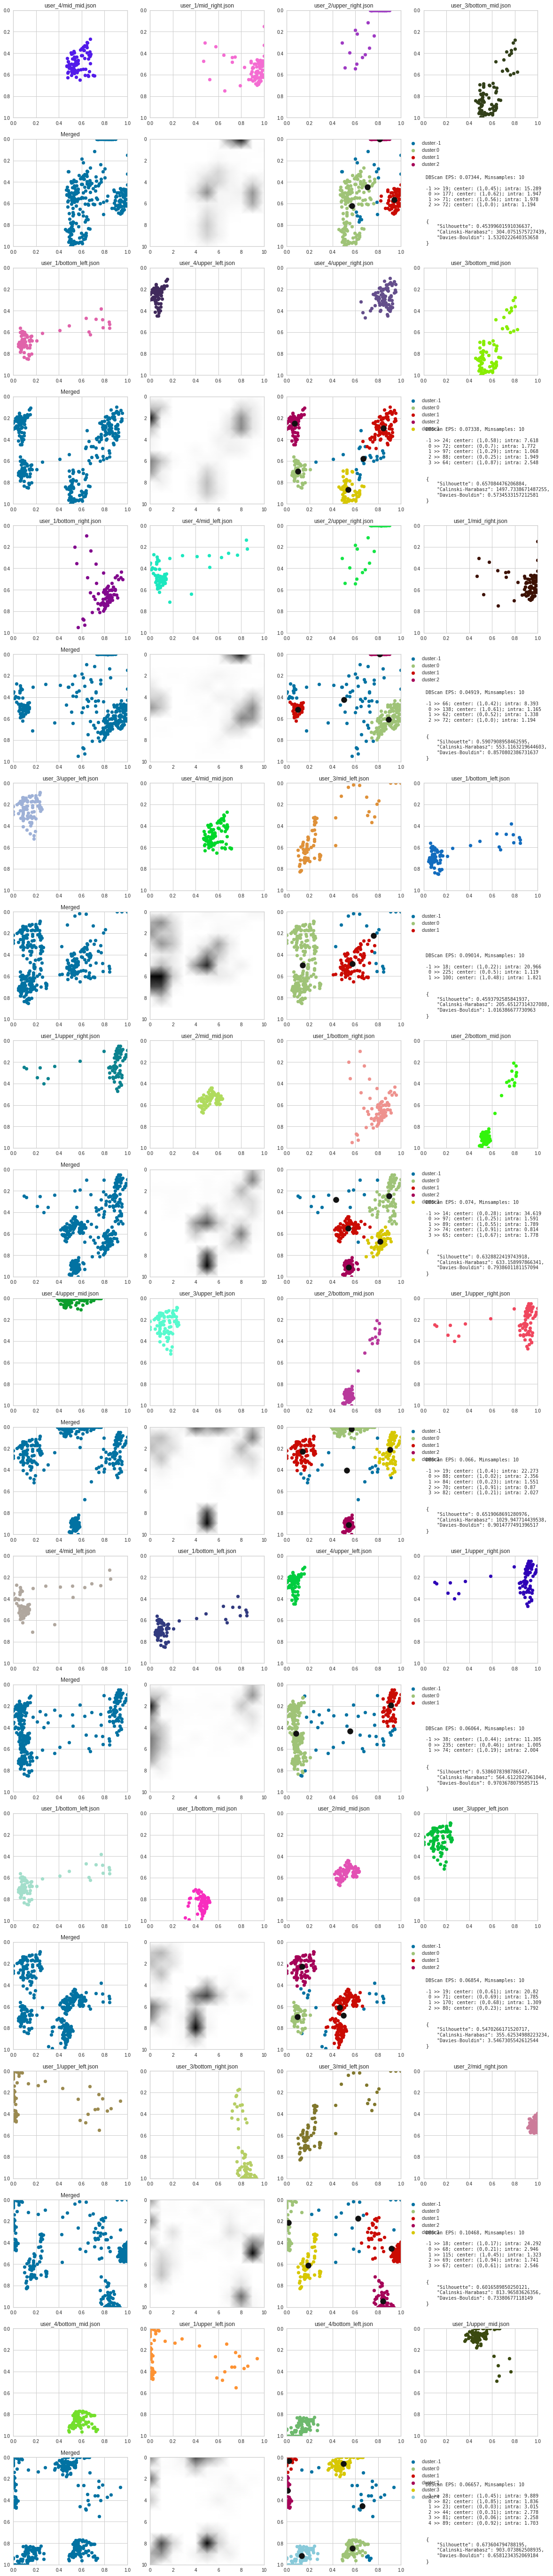

In [13]:
col_fix = 4
col_width = 20

plt.rcParams["figure.figsize"] = (col_width, limiter*2*col_width/col_fix)
fig, ax = plt.subplots(nrows=limiter*2, ncols=col_fix)

counter = 0
cur_limiter = min(limiter, len(path_all_combinations))
for path_arr in path_all_combinations:

    if(counter == cur_limiter):
        break

    X = None

    dataload_row = counter * 2 + 0
    analysis_row = counter * 2 + 1

    col = 0
    for path in path_arr:
        x_cur = loadGazeSession_session(path)
        if(X is not None):
            X = np.concatenate((X, x_cur), axis=0)
        else:
            X = x_cur

        sb_plot = ax[dataload_row, col]
        sb_plot.scatter(x=x_cur[:, 0], y=x_cur[:, 1], color=np.random.rand(3,))
        sb_plot.set_xlim([0,1])
        sb_plot.set_ylim([0,1])
        sb_plot.invert_yaxis()
        sb_plot.title.set_text(path)
        col += 1

    print(" >>>> Loaded dataset >>> ", X.shape)
    ##################################################################

    col = 0
    ax[analysis_row, col].scatter(X[:, 0], X[:, 1])
    ax[analysis_row, col].set_xlim([0,1])
    ax[analysis_row, col].set_ylim([0,1])
    ax[analysis_row, col].invert_yaxis()
    ax[analysis_row, col].title.set_text("Merged")
    col += 1
    ###################################################################
    heat_map = np.zeros((1001, 1001))
    for point in X:
        xx = int(point[0]*1000)
        yy = int(point[1]*1000)
        heat_map[yy, xx] += 1
    print("heatmap shape", heat_map.shape)
    heatmap_reduced = skimage.measure.block_reduce(heat_map, (100,100), np.mean)
    print(heatmap_reduced.shape, heatmap_reduced.min(), heatmap_reduced.max())
    print(">>>> ", col)
    ax[analysis_row, col].pcolormesh(np.arange(11), np.arange(11), heatmap_reduced, 
                    shading='gouraud', 
                    vmin=heatmap_reduced.min(), 
                    vmax=heatmap_reduced.max())
    ax[analysis_row, col].invert_yaxis()

    # np.random.seed(19680801)
    # Z = np.random.rand(11, 11)
    # x = np.arange(11)  # len = 11
    # y = np.arange(11)  # len = 7
    # print(Z.min(), Z.max())
    # ax[1, col].pcolormesh(x, y, Z,
    #                         shading='gouraud',
    #                         vmin = Z.min(),
    #                         vmax = Z.max() 
    #                     )
    col += 1
    ###################################################################

    nearest_neighbors = NearestNeighbors(n_neighbors=11)
    neighbors = nearest_neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)
    print(distances.shape, indices.shape)
    dist = np.sort(distances[:,10])
    i = np.arange(len(dist))
    kneedle = KneeLocator(i, dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    knee_val = dist[kneedle.knee]

    print("Knee >> ", knee_val)
    ###################################################################
    description = "DBScan EPS: {}, Minsamples: 10\n\n".format(round(knee_val, 5))
    model = DBSCAN(eps=knee_val, min_samples=10).fit(X)
    labels = model.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Number of clusters: ", n_clusters_)

    df = pd.DataFrame({
        "x0"    : X[:, 0],
        "x1"    : X[:, 1],
        "pred_y": labels
    })
    centroids = []

    for cluster in range(-1, n_clusters_):
        points_df = df[df["pred_y"] == cluster][["x0", "x1"]]
        single_cluster_attrs = getSingleCluster__attrs(points_df)
        cluster_name = "-1"
        if(cluster != -1):
            cluster_name = " {}".format(cluster)
        print("{} >> number of points: {}; center: {}; intra_cluster_dist: {}".format(
            cluster_name, len(points_df), single_cluster_attrs["center"] ,single_cluster_attrs["intra_dist"]))
        description += "{} >> {}; center: ({},{}); intra: {}\n".format(
            cluster_name, len(points_df), round(single_cluster_attrs["center"][0]), 
            round(single_cluster_attrs["center"][1],2), round(single_cluster_attrs["intra_dist"], 3))

        centroids.append(single_cluster_attrs["center"])
        ax[analysis_row, col].scatter(points_df["x0"], points_df["x1"], label = "cluster:{}".format(cluster))

    for center in centroids:
        ax[analysis_row, col].scatter(center[0] , center[1] , s = 150, color = 'k')

    ax[analysis_row, col].set_xlim([0,1])
    ax[analysis_row, col].set_ylim([0,1])
    ax[analysis_row, col].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[analysis_row, col].invert_yaxis()
    col += 1
    ####################################################################

    description += "\n\n"
    description += json.dumps({
        "Silhouette": silhouette_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels)
    }, indent=4)
    ax[analysis_row, col].set_xlim([0, 1])
    ax[analysis_row, col].set_ylim([0, 1])
    ax[analysis_row, col].text(0.02,0.02, description, family="monospace", fontsize=10)
    ax[analysis_row, col].axis('off')

    print(">>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<")
    counter += 1